关于实验，这部分是对学习率进行的探究。实验主要是分为两个部分
1：是关于学习率是横坐标，在相同的训练轮次下，看最后损失随着学习率的变化情况。
参数 m  =16，学习率从0.1变化到0.005 ，重复进行20次实验
此外变化snr和n进一步探究变化情况
2：关于训练轮次是横坐标，看不同的学习率下损失的变化情况。
m=16 ，学习率取了三个部分0，1、0，01、0，001，重复进行20次实验

In [11]:
import math
import numpy
import numpy as np
import torch
from torch import nn, optim

M = 2
d = 1024
n_ = 100
dh = 512
dv = 512
cp = 4
class TF(nn.Module):
    def __init__(self):
        super().__init__()
        self.q = nn.Linear(d, dh, bias=False)
        self.k = nn.Linear(d, dh, bias=False)
        self.v = nn.Linear(d, dv, bias=False)
        self.fc = nn.Linear(dv, 1, bias=False)
        self.fc.requires_grad_(False)
        self.q.weight.data /= 16
        self.k.weight.data /= 16
        self.v.weight.data /= 16


    def forward(self, x):
        q = self.q(x)
        k = self.k(x)
        v = self.v(x)
        qk = torch.matmul(q, k.transpose(1, 2))
        attn = qk.softmax(dim=2)
        attn = torch.sum(attn, dim=1).unsqueeze(1)
        attn /= 16
        z = torch.matmul(attn, v).squeeze(1)
        return self.fc(z)

def make_mu1(mu):
    mu1 = numpy.zeros(d)
    mu1[0] = mu
    return mu1

def make_mu2(mu):
    mu2 = numpy.zeros(d)
    mu2[1] = mu
    return mu2

def make_noise(strength):
    return numpy.random.normal(0, strength, size=d)

def get_test_loss(n, mu, p):
    D = []
    D_Y = []
    D_ = []
    D_Y_ = []

    mu1 = make_mu1(mu)
    mu2 = make_mu2(mu)

    D_mu = []
    D_mu_ = []

    for i in range(int(n / 2)):
        X = mu1.copy().reshape(1, d)
        X = numpy.concatenate((X, (make_noise(cp)).reshape(1, d)), 0)
        for j in range(M - 2):
            X = numpy.concatenate((X, (make_noise(0.2)).reshape(1, d)), 0)
        D.append(X)
        D_Y.append([1.])
        D_mu.append(mu1.reshape(1, d))
        X = mu2.copy().reshape(1, d)
        X = numpy.concatenate((X, (make_noise(cp)).reshape(1, d)), 0)
        for j in range(M - 2):
            X = numpy.concatenate((X, (make_noise(0.2)).reshape(1, d)), 0)
        D.append(X)
        D_Y.append([-1.])
        D_mu.append(mu2.reshape(1, d))

    D = torch.tensor(D, dtype=torch.float32).cuda()
    D_Y = torch.tensor(D_Y).cuda()

    for i in range(int(n_ / 2)):
        X = mu1.copy().reshape(1, d)
        X = numpy.concatenate((X, (make_noise(cp)).reshape(1, d)), 0)
        for j in range(M - 2):
            X = numpy.concatenate((X, (make_noise(0.2)).reshape(1, d)), 0)
        D_.append(X)
        D_Y_.append([1.])
        D_mu_.append(mu1.reshape(1, d))
        X = mu2.copy().reshape(1, d)
        X = numpy.concatenate((X, (make_noise(cp)).reshape(1, d)), 0)
        for j in range(M - 2):
            X = numpy.concatenate((X, (make_noise(0.2)).reshape(1, d)), 0)
        D_.append(X)
        D_Y_.append([-1.])
        D_mu_.append(mu2.reshape(1, d))

    D_ = torch.tensor(D_, dtype=torch.float32).cuda()
    D_Y_ = torch.tensor(D_Y_).cuda()

    model = TF().cuda()

    optimizer = optim.SGD(model.parameters(), lr=p, momentum=0)
    loss_fn = nn.SoftMarginLoss().cuda()
    EPOCHS = 2000

    for epoch in range(1, EPOCHS + 1):
        model.train()
        optimizer.zero_grad()
        output = model(D)

        training_loss = loss_fn(output, D_Y)
        training_loss.backward()
        optimizer.step()

        model.eval()
        output = model(D_)
        test_loss = loss_fn(output, D_Y_)

        
    return test_loss



def Get_test_loss(n, mu ,p):
    D = []
    D_Y = []
    D_ = []
    D_Y_ = []

    mu1 = make_mu1(mu)
    mu2 = make_mu2(mu)

    D_mu = []
    D_mu_ = []

    for i in range(int(n / 2)):
        X = mu1.copy().reshape(1, d)
        X = numpy.concatenate((X, (make_noise(cp)).reshape(1, d)), 0)
        for j in range(M - 2):
            X = numpy.concatenate((X, (make_noise(0.2)).reshape(1, d)), 0)
        D.append(X)
        D_Y.append([1.])
        D_mu.append(mu1.reshape(1, d))
        X = mu2.copy().reshape(1, d)
        X = numpy.concatenate((X, (make_noise(cp)).reshape(1, d)), 0)
        for j in range(M - 2):
            X = numpy.concatenate((X, (make_noise(0.2)).reshape(1, d)), 0)
        D.append(X)
        D_Y.append([-1.])
        D_mu.append(mu2.reshape(1, d))

    D = torch.tensor(D, dtype=torch.float32).cuda()
    D_Y = torch.tensor(D_Y).cuda()

    for i in range(int(n_ / 2)):
        X = mu1.copy().reshape(1, d)
        X = numpy.concatenate((X, (make_noise(cp)).reshape(1, d)), 0)
        for j in range(M - 2):
            X = numpy.concatenate((X, (make_noise(0.2)).reshape(1, d)), 0)
        D_.append(X)
        D_Y_.append([1.])
        D_mu_.append(mu1.reshape(1, d))
        X = mu2.copy().reshape(1, d)
        X = numpy.concatenate((X, (make_noise(cp)).reshape(1, d)), 0)
        for j in range(M - 2):
            X = numpy.concatenate((X, (make_noise(0.2)).reshape(1, d)), 0)
        D_.append(X)
        D_Y_.append([-1.])
        D_mu_.append(mu2.reshape(1, d))

    D_ = torch.tensor(D_, dtype=torch.float32).cuda()
    D_Y_ = torch.tensor(D_Y_).cuda()

    model = TF().cuda()

    optimizer = optim.SGD(model.parameters(), lr=p, momentum=0)
    loss_fn = nn.SoftMarginLoss().cuda()
    EPOCHS = 2000

    test_losses = []
    for epoch in range(1, EPOCHS + 1):
        model.train()
        optimizer.zero_grad()
        output = model(D)

        training_loss = loss_fn(output, D_Y)
        training_loss.backward()
        optimizer.step()

        model.eval()
        output = model(D_)
        test_loss = loss_fn(output, D_Y_)
        # return test_loss
        if epoch%20 == 0:
            test_losses.append(test_loss.item())

    return test_losses   


size = 20
n_scale = 2
mu_scale = 1
matrix = np.zeros((size, size))
matrix1 = np.zeros((size, size))
matrix2 = np.zeros((size, size))
# # 其他固定，学习率作为变化，n和snr发生变化，此时的训练轮次均为1000
# for n in range(size):
#     print(n)
#     for mu in range(size):
#         matrix[n, mu] = get_test_loss(100, 36 , 0.001*(mu+1))
# np.savetxt('α_n100_μ36.npy', matrix)

# for n in range(size):
#     print(n)
#     for mu in range(size):
#         matrix1[n, mu] = get_test_loss(100, 36 , 0.002*(mu+1))
# np.savetxt('', matrix1)

# for n in range(size):
#     print(n)
#     for mu in range(size):
#         matrix2[n, mu] = get_test_loss(100, 36 , 0.002*(mu+1))
# np.savetxt('n=100.npy', matrix2)


# 训练轮次作为横坐标，探究不同的学习率下的变化情况
# matrix3 = np.zeros((size, 100))
# for n in range(size):
#     print(n)
#     test_losses = Get_test_loss(100, 36, 0.1)
#     matrix3[n, :] = test_losses
# np.savetxt('α_0.1.npy', matrix3)

# matrix4 = np.zeros((size, 100))
# for n in range(size):
#     print(n)
#     test_losses = Get_test_loss(100, 36, 0.01)
#     matrix4[n, :] = test_losses
# np.savetxt('α_0.01.npy', matrix4)

matrix5 = np.zeros((size, 100))
for n in range(size):
    print(n)
    test_losses = Get_test_loss(100, 36, 0.005)
    matrix5[n, :] = test_losses
np.savetxt('α_0.005.npy', matrix5)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


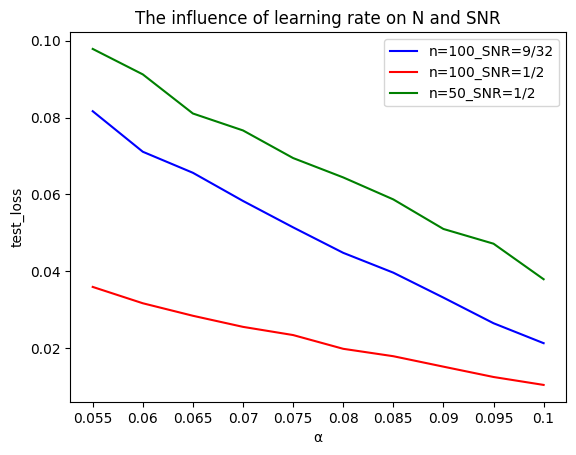

In [10]:
# 学习率是横坐标

import numpy as np
import matplotlib.pyplot as plt

# 加载npy文件中的矩阵
matrix1 = np.loadtxt('α_n100_μ36.npy')
matrix2 = np.loadtxt('α_n100_μ64.npy')
matrix3 = np.loadtxt('α_n50_μ36.npy')


# 计算每个矩阵列方向的平均值
mean_matrix1 = np.mean(matrix1, axis=0)
mean_matrix2 = np.mean(matrix2, axis=0)
mean_matrix3 = np.mean(matrix3, axis=0)


# 假设要均匀抽出10条数据
num_samples = 10
sample_indices = np.linspace(0, len(mean_matrix1) - 1, num_samples, dtype=int)

# 抽取数据
sampled_matrix1 = list(reversed(mean_matrix1[sample_indices]))
sampled_matrix2 = list(reversed(mean_matrix2[sample_indices]))
sampled_matrix3 = list(reversed(mean_matrix3[sample_indices]))


# 生成x轴数据
x = np.arange(num_samples)

# 绘制折线图
plt.plot(x, sampled_matrix1, label='n=100_SNR=9/32', color='blue')
plt.plot(x, sampled_matrix2, label='n=100_SNR=1/2', color='red')
plt.plot(x, sampled_matrix3, label='n=50_SNR=1/2', color='green')


# 添加图例
plt.legend()

# 添加标题和坐标轴标签


plt.xlabel('α')
plt.ylabel('test_loss')
plt.xticks(x,list(reversed([0.1, 0.095, 0.09, 0.085, 0.08, 0.075, 0.07, 0.065, 0.06, 0.055])))
# 显示折线图
plt.show()

# plt.savefig('学习率对损失的影响.png', dpi=1200, bbox_inches='tight')


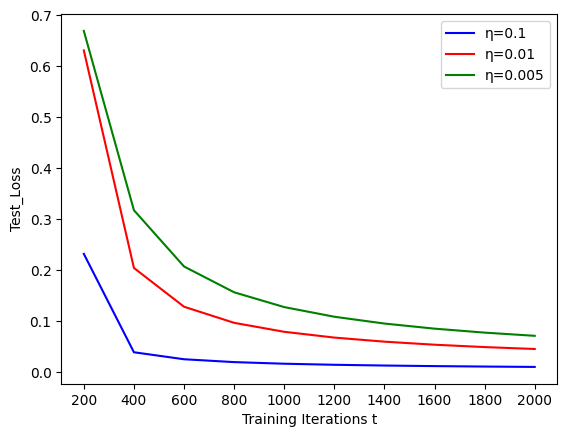

In [13]:
# 迭代次数是横坐标，探究不同的学习率对损失的影响

import numpy as np
import matplotlib.pyplot as plt

# 加载npy文件中的矩阵
matrix1 = np.loadtxt('α_0.1.npy')
matrix2 = np.loadtxt('α_0.01.npy')
matrix3 = np.loadtxt('α_0.005.npy')


# 计算每个矩阵列方向的平均值
mean_matrix1 = np.mean(matrix1, axis=0)
mean_matrix2 = np.mean(matrix2, axis=0)
mean_matrix3 = np.mean(matrix3, axis=0)


# 假设要均匀抽出10条数据
num_samples = 10
sample_indices = np.linspace(0, len(mean_matrix1) - 1, num_samples, dtype=int)

# 抽取数据
sampled_matrix1 = mean_matrix1[sample_indices]
sampled_matrix2 = mean_matrix2[sample_indices]
sampled_matrix3 = mean_matrix3[sample_indices]


# 生成x轴数据
x = np.arange(num_samples)

# 绘制折线图
plt.plot(x, sampled_matrix1, label='η=0.1', color='blue')
plt.plot(x, sampled_matrix2, label='η=0.01', color='red')
plt.plot(x, sampled_matrix3, label='η=0.005', color='green')


# 添加图例
plt.legend()

# 添加标题和坐标轴标签


plt.xlabel('Training Iterations t')
plt.ylabel('Test_Loss')
plt.xticks(x,[200,400,600,800,1000,1200,1400,1600,1800,2000])
# 显示折线图

plt.savefig('learning_rate.png', dpi=300, bbox_inches='tight')
plt.show()


